<a href="https://colab.research.google.com/github/sanchit45/Practice/blob/main/vulgartextdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing libraries

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import random
import re
import csv
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### #**preprocessing**

In [ ]:
Data = r"/content/vulgarclassifierdataset.csv"

In [ ]:
df = pd.read_csv(Data,engine='python' )

df=df[["text","Label"]]
df.sample(6666)

print(df)

In [ ]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
text = " ".join(str(i) for i in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print('Number of records:', len(df), '\n')
print('Number of nonvulgar text:', len(df[df.Label == 0]))
print('Number of vulgar text:', len(df[df.Label == 1]), '\n')

print('Example vulgar text:')
print(df[df.Label == 1]["text"].sample(), '\n')
print('Example nonvulgar text:')
print(df[df.Label == 0]["text"].sample(), '\n')

In [ ]:
df.head(40)

In [ ]:
testcorpus="Buddhism besides the historical Buddha,0 leaves on the water and some raise their leaves above the,0  love it if all nazis gathered and finished their duty"

In [ ]:
# remove special characters & lowercase
clean_corpus = re.sub(r'[^a-zA-Z\s]', '', testcorpus)
clean_corpus = clean_corpus.lower()
clean_corpus

In [ ]:
# tokenize
clean_tokens = wordpunct_tokenize(clean_corpus)
print(clean_tokens)


In [ ]:
for token in clean_tokens:
  token=re.sub(r'[^\w\s]', '', token)
  if len(token)<1:
    clean_tokens.remove(token)

print(clean_tokens)

In [ ]:
lemmatizer = WordNetLemmatizer()
clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
clean_tokens = [lemmatizer.lemmatize(token, "v") for token in clean_tokens]
print(clean_tokens)

In [ ]:
clean_tokens = [re.sub(r'\b[0-9]+\b', '<NUM>', token) for token in clean_tokens]
print(clean_tokens)

In [ ]:
stop_words = set(stopwords.words('english'))
clean_tokens = [token for token in clean_tokens if token not in stop_words]
print(clean_tokens)

In [ ]:
def build_vocab(corpus):
    vocab = {}
    for doc in corpus:
        for token in doc:
            if token not in vocab.keys():
                vocab[token] = len(vocab)
    return vocab

print(build_vocab([clean_tokens]))

In [ ]:


def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token

print(build_index2token(build_vocab([clean_tokens])))

In [ ]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [ ]:
doc=list(build_vocab([clean_tokens]).keys())
print(doc)
sequence=[token_idx_mapping[token] for token in doc if token in token_idx_mapping]
print(sequence)
idx2token=idx_token_mapping
print(idx2token)
print(build_bow_vector(sequence, idx2token))

# Dataset

In [ ]:
# Set parameters

MAX_LEN = 128 #@param [64, 256, 512, 1024] {allow-input: true}
MAX_VOCAB = 1000 #@param [1000, 5000, 10000, 100000] {allow-input: true}

In [ ]:
class VulgarDataset(Dataset):
    def __init__(self, datapath, max_vocab=5000, max_len=128):
        df = pd.read_csv(datapath,engine='python' )
        df=df[["text","Label"]]

        def makestr(text):
          return str(text)
        df["text"]=df["text"].apply(makestr)

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.text.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )

        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # Build most common tokens bound by max vocab size
        common_tokens = set(
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0]
        )

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )

        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]

        self.text = df.text.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.Label.tolist()

    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )

    def __len__(self):
        return len(self.targets)

In [ ]:
dataset = VulgarDataset(Data, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

100%|██████████| 18738/18738 [00:00<00:00, 35179.80it/s]


In [ ]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')
print(bow_vector)
print(tfidf_vector)

Number of records: 18738 

index: 7372 

fight with each other king against king vassal against 

[368, 533, 533, 1] 

BoW vector size: 1001 

TF-IDF vector size: 1001 

Sentiment: 0 

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.15, test_ratio=0.15):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [ ]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(16866, 936, 936)

In [ ]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [ ]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')

## #BoW Model

In [ ]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_labels)

    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


In [ ]:
HIDDEN1 = 100
HIDDEN2 = 50

In [ ]:
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=1001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([100, 1001])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([2, 50])
torch.Size([2])


In [ ]:
LEARNING_RATE = 5e-4

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 1.31e-03	valid_loss: 1.46e-03

epoch #  2	train_loss: 1.25e-03	valid_loss: 1.34e-03

epoch #  3	train_loss: 1.12e-03	valid_loss: 1.18e-03

epoch #  4	train_loss: 9.88e-04	valid_loss: 1.07e-03

epoch #  5	train_loss: 9.16e-04	valid_loss: 1.01e-03

epoch #  6	train_loss: 8.71e-04	valid_loss: 9.62e-04

epoch #  7	train_loss: 8.32e-04	valid_loss: 9.17e-04

epoch #  8	train_loss: 7.91e-04	valid_loss: 8.73e-04

epoch #  9	train_loss: 7.54e-04	valid_loss: 8.36e-04

epoch # 10	train_loss: 7.25e-04	valid_loss: 8.10e-04

epoch # 11	train_loss: 7.04e-04	valid_loss: 7.93e-04

epoch # 12	train_loss: 6.89e-04	valid_loss: 7.81e-04

epoch # 13	train_loss: 6.79e-04	valid_loss: 7.72e-04

epoch # 14	train_loss: 6.72e-04	valid_loss: 7.66e-04

epoch # 15	train_loss: 6.67e-04	valid_loss: 7.62e-04

epoch # 16	train_loss: 6.62e-04	valid_loss: 7.58e-04

epoch # 17	train_loss: 6.59e-04	valid_loss: 7.55e-04

epoch # 18	train_loss: 6.56e-04	valid_loss: 7.53e-04

epoch # 19	train_loss: 6.54e

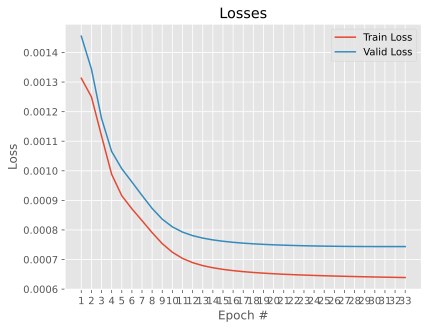

In [ ]:


epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [ ]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:

        inputs = bow
        probs = bow_model(inputs)
        if input_type == 'tdidf':
            inputs = tfidf
            probs = tfidf_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(target )
        y_pred.extend(predictions)

print(predictions)
print(classification_report(y_true, y_pred))

[1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1
 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0
 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1
 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1
 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0
 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0
 1]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       300
           1       0.98      0.96      0.97       636

    acc

In [ ]:
print(bow_model)

FeedfowardTextClassifier(
  (fc1): Linear(in_features=1001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [ ]:
model=bow_model
path= r"/content/drive/MyDrive/bow.pth"
model.to("cpu")
checkpoint={"state_dict":model.state_dict(),
            "token2idx":dataset.token2idx ,
            "index2token":dataset.idx2token}
torch.save(checkpoint,path)

#TF-IDF Model

In [ ]:
HIDDEN1 = 100
HIDDEN2 = 50

In [ ]:
tfidf_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
tfidf_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=1001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
LEARNING_RATE = 5e-5

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 1.32e-03	valid_loss: 1.49e-03

epoch #  2	train_loss: 1.32e-03	valid_loss: 1.49e-03

epoch #  3	train_loss: 1.32e-03	valid_loss: 1.48e-03

epoch #  4	train_loss: 1.32e-03	valid_loss: 1.48e-03

epoch #  5	train_loss: 1.32e-03	valid_loss: 1.48e-03

epoch #  6	train_loss: 1.31e-03	valid_loss: 1.48e-03

epoch #  7	train_loss: 1.31e-03	valid_loss: 1.48e-03

epoch #  8	train_loss: 1.31e-03	valid_loss: 1.47e-03

epoch #  9	train_loss: 1.31e-03	valid_loss: 1.47e-03

epoch # 10	train_loss: 1.31e-03	valid_loss: 1.47e-03

epoch # 11	train_loss: 1.30e-03	valid_loss: 1.47e-03

epoch # 12	train_loss: 1.30e-03	valid_loss: 1.46e-03

epoch # 13	train_loss: 1.30e-03	valid_loss: 1.46e-03

epoch # 14	train_loss: 1.29e-03	valid_loss: 1.46e-03

epoch # 15	train_loss: 1.29e-03	valid_loss: 1.45e-03

epoch # 16	train_loss: 1.29e-03	valid_loss: 1.45e-03

epoch # 17	train_loss: 1.28e-03	valid_loss: 1.44e-03

epoch # 18	train_loss: 1.28e-03	valid_loss: 1.44e-03

epoch # 19	train_loss: 1.27e

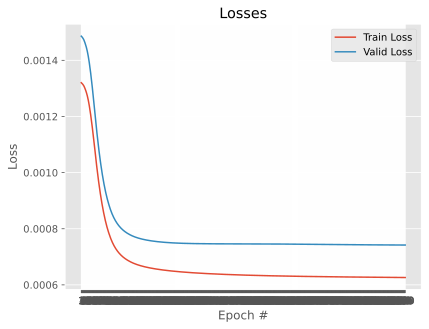

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [ ]:


tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(target )
        y_pred.extend(predictions)

print(predictions)
print(classification_report(y_true, y_pred))

[1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1
 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1
 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1
 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1
 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0
 1]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       300
           1       0.97      0.97      0.97       636

    acc

In [ ]:
model=tfidf_model
path= r"/content/drive/MyDrive/tfidf.pth"
model.to("cpu")
checkpoint={"state_dict":model.state_dict()
            }
torch.save(checkpoint,path)

## #inference

# text preprocessing

In [ ]:
def build_vocab(corpus):
    vocab = {}
    for token in corpus:
        if token not in vocab.keys():
              vocab[token] = len(vocab)
    return vocab

def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

def preprocess(data,token_idx_mapping,idx_token_mapping,feature):

        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        tokens=tokenize(data, stop_words, lemmatizer)
        vocab=build_vocab(tokens)
        index2token=build_index2token(vocab)

        doc=list(vocab.keys())
        sequence=[token_idx_mapping[token] for token in doc if token in token_idx_mapping]
        idx2token=idx_token_mapping
        bow_vector=build_bow_vector(sequence, idx2token)

         # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        tfidf_vectors = vectorizer.fit_transform(tokens).toarray()
        #tfidf_vector = tfidf_vectors.tolist()
        tfidf_vector = [vector.tolist() for vector in tfidf_vectors]
        print(tfidf_vector)


In [ ]:
data="If Jews have a right to set up their ethnostate Israel then Whites have a right to a country of their own free of external control of its centers of power and so do Blacks"

preprocess(data,token_idx_mapping,idx_token_mapping,feature="tfidf")

[[0.0, 0.0, 0.0, 0.0, 0.5773502691896257, 0.5773502691896257, 0.5773502691896257], [0.4736296010332684, 0.0, 0.6227660078332259, 0.6227660078332259, 0.0, 0.0, 0.0], [0.6053485081062916, 0.7959605415681652, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [ ]:
bow_model.eval()
bow_model.to(device)
y_pred = []


with torch.no_grad():

        inputs = preprocess(data,token_idx_mapping,idx_token_mapping,feature="bow")
        probs = bow_model.forward([inputs])


        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        y_pred.extend(predictions)


print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
tfidf_model.eval()
tfidf_model.to(device)
y_pred = []

with torch.no_grad():
        inputs = preprocess(data,token_idx_mapping,idx_token_mapping,feature="tfidf")
        probs = tfidf_model.forward([inputs])


        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        y_pred.extend(predictions)


print(y_pred)